# 2. Notebooks . Introduction to Ensembling_Stacking in Python 연습하기

URL : https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# Introduction

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

PassengerId = test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


|  <center>Variable<center>  |  <center>Definition<center>  |  <center>Key<center>  |
|:---------------------------|:----------------------------:|----------------------:|
|survived|Survival|<center>0=No, 1=Yes<center>|
|pcalss|Ticket class|<center>   1 = 1st,  2 = 2nd, 3 = 3rd  <center> |
|sex|Sex|
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic|
|parch|# of parents / children aboard the Titanic|
|ticket|Ticket number|
|fare|Passenger fare|
|cabin|Cabin number|
|embarked|Port of Embarkation| C = Cherbourg, Q = Queenstown, S = Southampton   |

# 아래 식은 1. Notebooks. Titanic best working Classifier prac.ipynb 참조

혹은 URL 참조 : https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

In [3]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [4]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [6]:
train.shape

(891, 12)

In [7]:
train.describe()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.347924,0.381594,1.505051,0.361392,26.965208,0.228956,1.904602,0.602694,1.728395
std,0.486592,0.836071,0.477990,0.845440,0.806057,1.118148,0.635673,9.281607,0.420397,1.613459,0.489615,1.030039
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,1.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,2.000000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,4.000000,6.000000,3.000000,2.000000,82.000000,1.000000,11.000000,1.000000,5.000000


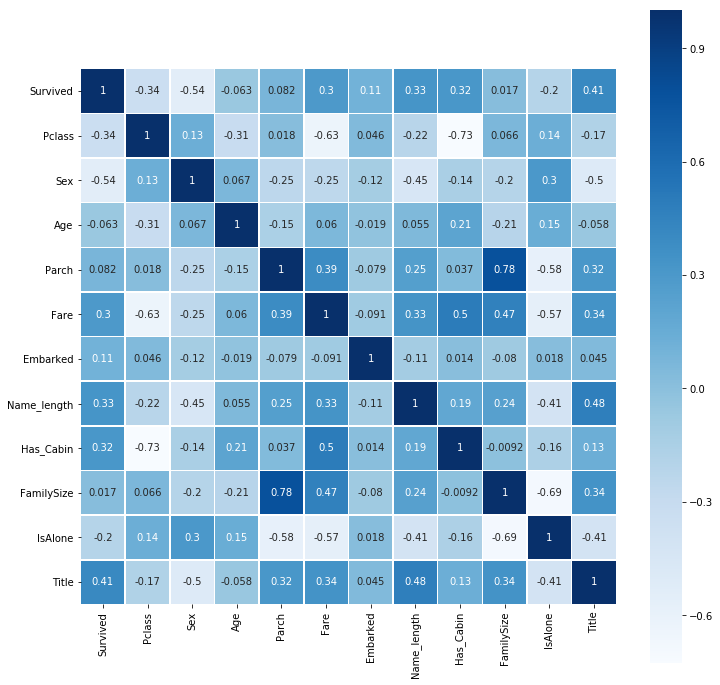

In [8]:
plt.figure(figsize=(12,12))
heat = sns.heatmap(train.astype('float').corr(), linewidths=0.5, square=True, cmap='Blues', annot=True)
plt.show()

```python
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])
```

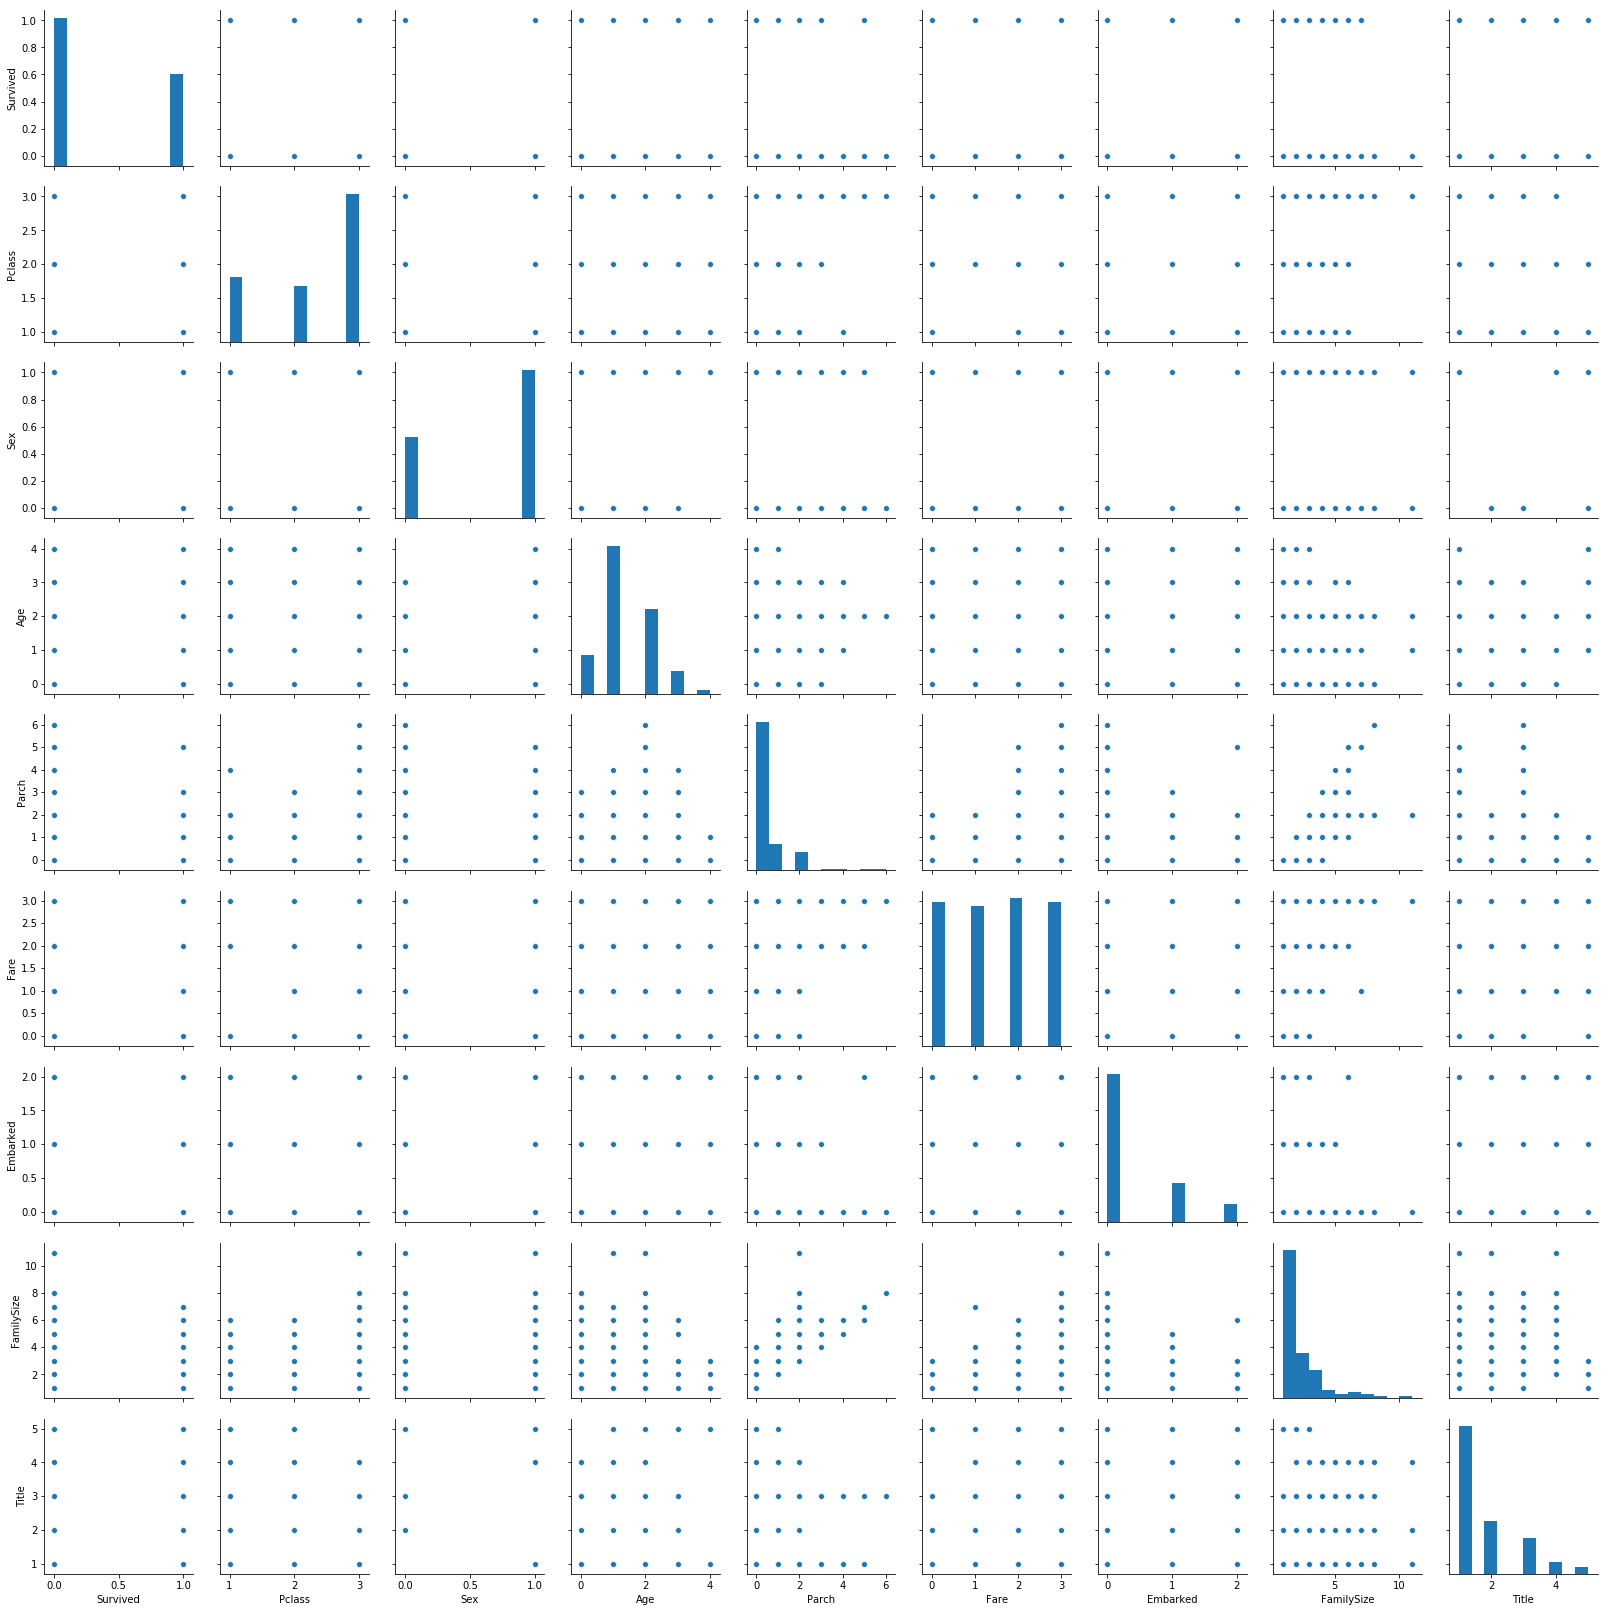

In [9]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']])

# Ensembling & Stacking models

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED).split(ntrain)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [11]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

In [12]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [13]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [14]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values
x_test = test.values

In [16]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) 
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) 
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) 
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) 
print("Training is complete")

Training is complete


In [17]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.11167021 0.23997137 0.03360481 0.01888434 0.04795862 0.02316832
 0.11288175 0.06647155 0.07037668 0.0117608  0.26325154]
[0.12040937 0.37612353 0.02926463 0.01701767 0.05636085 0.0285017
 0.04755394 0.08322652 0.04343369 0.02254249 0.1755656 ]
[0.03  0.01  0.016 0.066 0.036 0.01  0.69  0.012 0.054 0.004 0.072]
[0.08495834 0.01222478 0.05586999 0.01228748 0.05112294 0.02468974
 0.17135537 0.03725929 0.11462451 0.00698983 0.4286177 ]


In [19]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

[0.11167021 0.23997137 0.03360481 0.01888434 0.04795862 0.02316832
 0.11288175 0.06647155 0.07037668 0.0117608  0.26325154]
[0.12040937 0.37612353 0.02926463 0.01701767 0.05636085 0.0285017
 0.04755394 0.08322652 0.04343369 0.02254249 0.1755656 ]
[0.03  0.01  0.016 0.066 0.036 0.01  0.69  0.012 0.054 0.004 0.072]
[0.08495834 0.01222478 0.05586999 0.01228748 0.05112294 0.02468974
 0.17135537 0.03725929 0.11462451 0.00698983 0.4286177 ]


In [20]:
cols = train.columns.values
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [21]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,None,None,None,None
1,Sex,None,None,None,None
2,Age,None,None,None,None
3,Parch,None,None,None,None
4,Fare,None,None,None,None
5,Embarked,None,None,None,None
6,Name_length,None,None,None,None
7,Has_Cabin,None,None,None,None
8,FamilySize,None,None,None,None
9,IsAlone,None,None,None,None


In [22]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

In [23]:
feature_dataframe['features'].values

array(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'], dtype=object)

In [24]:
layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [26]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,None,None,None,None,NaN
1,Sex,None,None,None,None,NaN
2,Age,None,None,None,None,NaN
